In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os

In [3]:
# Laden Sie Ihre xarray-Datensätze
INALT = xr.open_mfdataset('/gxfs_work1/geomar/smomw044/prep_data_iAtlantic_LMock/INALT20.L46-KFS119/SSH/1_INALT20.L46-KFS119_1d_20090101_20091231_zeromean_Agulhasringpath.nc')
ROMS = xr.open_mfdataset('/gxfs_work1/geomar/smomw523/master-thesis/data/config/ROMS/roms_avg02_2009_datetime.nc')
ROMSchild = xr.open_mfdataset('/gxfs_work1/geomar/smomw523/master-thesis/data/config/ROMS/roms_avg02_2009_datetime.nc.1')

# Wählen Sie die gewünschten Zeitpunkte aus
start_date = '2009-04-01T00:00:00.000000000'
end_date = '2009-05-01T00:00:00.000000000'
variable1 = INALT.isel(x=slice(290,411),y=slice(669,820)).sel(time_counter=slice(start_date, end_date)).rename_dims({"time_counter": "time"}).sossheig
variable1 -= variable1.mean(dim={'x','y'})
variable2 = ROMS.zeta.sel(time=slice(start_date, end_date))
variable2 -= variable2.mean(dim={'eta_rho','xi_rho'})
variable3 = ROMSchild.zeta.sel(time=slice(start_date, end_date))
variable3 -= variable3.mean(dim={'eta_rho','xi_rho'})

# Erstellen Sie eine Liste von Zeitpunkten, die Sie im GIF darstellen möchten
zeitpunkte = range(0, len(variable1.time))

In [4]:
lon_values = np.linspace(INALT.isel(x=slice(290,411),y=slice(669,820)).nav_lon.values.min(),
                       INALT.isel(x=slice(290,411),y=slice(669,820)).nav_lon.values.max(),
                       121)
lat_values = np.linspace(INALT.isel(x=slice(290,411),y=slice(669,820)).nav_lat.values.min(),
                       INALT.isel(x=slice(290,411),y=slice(669,820)).nav_lat.values.max(),
                       151)
lon_values_R = np.linspace(ROMS.lon_rho.values.min(),
                       ROMS.lon_rho.values.max(),
                       238)
lat_values_R = np.linspace(ROMS.lat_rho.values.min(),
                       ROMS.lat_rho.values.max(),
                       258)
lon_values_RC = np.linspace(ROMSchild.lon_rho.values.min(),
                       ROMSchild.lon_rho.values.max(),
                       266)
lat_values_RC = np.linspace(ROMSchild.lat_rho.values.min(),
                       ROMSchild.lat_rho.values.max(),
                       266)

In [5]:
variable1 = xr.DataArray(variable1.values, coords={'lon': lon_values, 'lat': lat_values, 'time': pd.date_range(start='2009-04-01', end='2009-04-30')}, dims=['time', 'lat', 'lon'])
variable2 = xr.DataArray(variable2.values, coords={'lon': lon_values_R, 'lat': lat_values_R, 'time': pd.date_range(start='2009-04-01', end='2009-04-30')}, dims=['time', 'lat', 'lon'])
variable3 = xr.DataArray(variable3.values, coords={'lon': lon_values_RC, 'lat': lat_values_RC, 'time': pd.date_range(start='2009-04-01', end='2009-04-30')}, dims=['time', 'lat', 'lon'])

/tmp/ipykernel_3744926/550807602.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["{:.1f}".format(label) for label in ax.get_xticks()], backgroundcolor='white')
/tmp/ipykernel_3744926/550807602.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticks(), backgroundcolor='white')


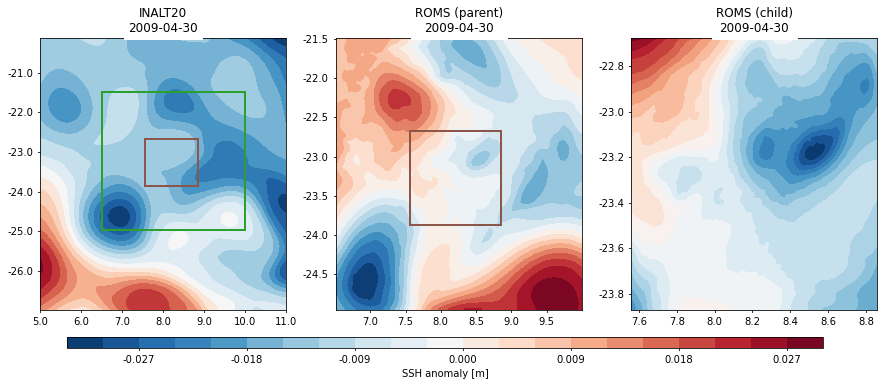

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

cbar_ax = fig.add_axes([0.15, 0.02, 0.7, 0.03]) 
cbar = None

def plot_single_frame(time_index, save_path):
    global cbar  # Gemeinsame Colorbar über alle Schleifeniterationen
    
    for ax, variable, title in zip(axs, [variable1, variable2, variable3], ['INALT20', 'ROMS (parent)', 'ROMS (child)']):
        ax.cla()
        
        contourf = ax.contourf(variable.lon,variable.lat,variable.isel(time=time_index), cmap='RdBu_r',levels=21)
        if variable is variable1:
            rectangle_R = patches.Rectangle((lon_values_R.min(), lat_values_R.min()),
                                          (lon_values_R.max()-lon_values_R.min()),
                                          (lat_values_R.max()-lat_values_R.min()),
                                            linewidth=2, edgecolor='tab:green', facecolor='none')
            ax.add_patch(rectangle_R)
            rectangle_RC = patches.Rectangle((lon_values_RC.min(), lat_values_RC.min()),
                                          (lon_values_RC.max()-lon_values_RC.min()),
                                          (lat_values_RC.max()-lat_values_RC.min()),
                                             linewidth=2, edgecolor='tab:brown', facecolor='none')
            ax.add_patch(rectangle_RC)
        if variable is variable2:
            rectangle_RC = patches.Rectangle((lon_values_RC.min(), lat_values_RC.min()),
                                          (lon_values_RC.max()-lon_values_RC.min()),
                                          (lat_values_RC.max()-lat_values_RC.min()),
                                             linewidth=2, edgecolor='tab:brown', facecolor='none')
            ax.add_patch(rectangle_RC)
        # Ändern Sie die Hintergrundfarbe des Titels und der Labels
        ax.set_title(f'{title}\n2009-04-{(time_index+1):02d}', backgroundcolor='white')
        ax.set_facecolor('white')
        ax.set_xticklabels(["{:.1f}".format(label) for label in ax.get_xticks()], backgroundcolor='white')
        ax.set_yticklabels(ax.get_yticks(), backgroundcolor='white')
    
    if cbar is None:
        cbar = plt.colorbar(contourf, cax=cbar_ax, orientation='horizontal')
        cbar.set_label('SSH anomaly [m]', backgroundcolor='white') 
        tick_locations = cbar.get_ticks()
        formatted_labels = ["{:.3f}".format(label) for label in tick_locations]

        cbar.set_ticks(tick_locations)
        cbar.set_ticklabels(formatted_labels, backgroundcolor='white')
        cbar.ax.set_facecolor('white')
    
    plt.savefig(save_path, bbox_inches='tight')

output_path = 'temp_frames/'
os.makedirs(output_path, exist_ok=True)

frames = []
for time_index in zeitpunkte:
    frame_filename = f'{output_path}frame_{time_index:04d}.png'
    plot_single_frame(time_index, frame_filename)
    frames.append(frame_filename)

output_gif = 'april_ssh.gif'
images = [Image.open(frame) for frame in frames]
images[0].save(
    output_gif,
    save_all=True,
    append_images=images[1:],
    duration=500 
)

for frame in frames:
    os.remove(frame)